Basic Walkthrough:
     1) Define everything
     2) Create master bias file, Save master bias file  
     3) Open all other files, sub master bias, save  (*c?.b.fits)
     4) Remove cosmics from all file types except bias  (*c?.bc.fits)
     5) Open flats and create master skyflat file, save
     6) Open all remainging types and divide out master flat, then save  (*c?.bcf.fits)
     7) Open all remaining types and stitch together, save  (*full.bcf.fits)
     8) Use fibermap files to determine aperatures
     9) Use aperatures to cut out same regions in thar,comp,science
     10) Save all 256 to files with their header tagged name in filename, along with fiber num
     11) Assume no curvature within tiny aperature region; fit profile to 2d spec and sum to 1d
     12) Fit the lines in comp spectra, save file and fit solution
     13) Try to fit lines in thar spectra, save file and fit solution
     14) Apply to science spectra

In [1]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Define input file numbers and other required information

Ex:

    Bias 597-626
    ThAr 627,635
    NeHgArXe 628,629,636,637
    Science 631-634
    Fibermaps 573-577


In [2]:
biass = np.arange(597,626+1).astype(int)
thar_lamps = np.asarray([627,635])
comp_lamps = np.asarray([628,629,636,637])
twiflats = np.arange(582,591+1).astype(int)
sciences = np.arange(631,634+1).astype(int)
fibermaps = np.arange(573,577+1).astype(int)

In [3]:
instrument = 'M2FS'
mask_name = 'A02'
cal_lamp = ['Xenon', 'Argon', 'HgNe']  # 'Xenon','Argon','Neon', 'HgNe'
cameras = ['r']
opamps = [1,2,3,4]

In [4]:
path_to_masks = os.path.abspath('../../OneDrive/Research/M2FSReductions')
mask_subdir = mask_name
raw_data_subdir =  'raw_data'
raw_filename_template = '{cam}{filenum:04d}c{opamp}.fits'

In [5]:
make_debug_plots = False
print_headers = True
cut_bias_cols = True
convert_adu_to_e = True

In [6]:
do_stitch = True
do_bias = True
do_cr   = True
do_flat = True
do_apcut = True
do_2dto1d = True
do_wavecalib = True
do_combine = True
do_zfit = True

###         Beginning of Code

In [7]:
date = np.datetime_as_string(np.datetime64('today', 'D'))

In [8]:
mask_dir = os.path.join(path_to_masks,mask_subdir)

In [9]:
raw_data_dir =     os.path.join(mask_dir, raw_data_subdir)
raw_stitched_dir = os.path.join(mask_dir,'raw_stitched')
product_dir =      os.path.join(mask_dir,'data_products')
twod_dir =         os.path.join(mask_dir,'twods')
oned_dir =         os.path.join(mask_dir,'oneds')
calibrated_dir =   os.path.join(mask_dir,'calibrated_oned')
summedspec_dir =   os.path.join(mask_dir,'final_oned')
zfit_dir =         os.path.join(mask_dir,'zfits')

for folder in [ raw_data_dir, raw_stitched_dir, product_dir, twod_dir, 
    oned_dir, calibrated_dir, summedspec_dir, zfit_dir]:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [10]:
fibermap_array_dict, fibermap_header_dict = None,None
twiflat_array_dict, twiflat_header_dict = None,None
bias_array_dict, bias_header_dict = None,None

In [11]:
headers = None
data = None
master_aux_data = {}
master_aux_headers = {}

In [12]:
filenumbers = {'bias':biass, 'thar':thar_lamps, 'comp': comp_lamps,
               'twiflat':twiflats, 'science': sciences, 'fibmap': fibermaps}

In [13]:
base_file_template =          '{cam}_{imtype}_{filenum:04d}_{maskname}_'
stitched_filename_template =  base_file_template+'stitched{tags}.fits'
twod_filename_template =      base_file_template+'{fibername}_2d{tags}.fits'
oned_filename_template =      base_file_template+'{fibername}_1d{tags}.fits'
combined_filename_template =  base_file_template+'{fibername}_1d{tags}.fits'

master_stitched_fname_template =  '{cam}_master{imtype}_{maskname}_stitched{tags}.fits'

In [14]:
common_info =      {    'maskname':      mask_name,
                        'cameras':       cameras,
                        'opamps':        opamps, 
                        'date':          date,
                        'datadir':       raw_data_dir,
                        'template':      raw_filename_template,
                        'tags':          ''                      }

In [15]:
from quickreduce_funcs import get_all_filedata

if do_stitch:
    ## Load in data
    data, headers = get_all_filedata( filenum_dict=filenumbers, **common_info,
                                      cut_bias_cols=cut_bias_cols, convert_adu_to_e = convert_adu_to_e )

In [16]:
## Update values to stitched directory and filenames for future saving/loading
common_info['datadir'] = raw_stitched_dir
common_info['template'] = stitched_filename_template

stitched_data, stitched_headers = None, None

Imtype: thar  In filenum: 627 Camera: r Opamp: 1 located at ur
Imtype: thar  In filenum: 627 Camera: r Opamp: 2 located at ul
Imtype: thar  In filenum: 627 Camera: r Opamp: 3 located at bl
Imtype: thar  In filenum: 627 Camera: r Opamp: 4 located at br


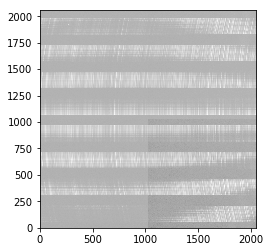

Imtype: thar  In filenum: 635 Camera: r Opamp: 1 located at ur
Imtype: thar  In filenum: 635 Camera: r Opamp: 2 located at ul
Imtype: thar  In filenum: 635 Camera: r Opamp: 3 located at bl
Imtype: thar  In filenum: 635 Camera: r Opamp: 4 located at br


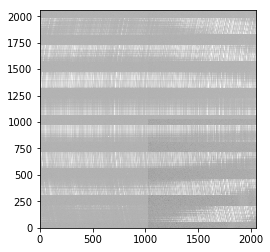

Imtype: comp  In filenum: 628 Camera: r Opamp: 1 located at ur
Imtype: comp  In filenum: 628 Camera: r Opamp: 2 located at ul
Imtype: comp  In filenum: 628 Camera: r Opamp: 3 located at bl
Imtype: comp  In filenum: 628 Camera: r Opamp: 4 located at br


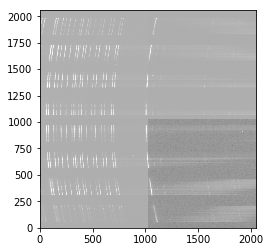

Imtype: comp  In filenum: 629 Camera: r Opamp: 1 located at ur
Imtype: comp  In filenum: 629 Camera: r Opamp: 2 located at ul
Imtype: comp  In filenum: 629 Camera: r Opamp: 3 located at bl
Imtype: comp  In filenum: 629 Camera: r Opamp: 4 located at br


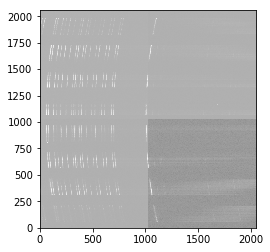

Imtype: comp  In filenum: 636 Camera: r Opamp: 1 located at ur
Imtype: comp  In filenum: 636 Camera: r Opamp: 2 located at ul
Imtype: comp  In filenum: 636 Camera: r Opamp: 3 located at bl
Imtype: comp  In filenum: 636 Camera: r Opamp: 4 located at br


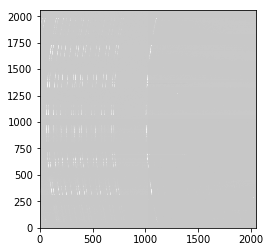

Imtype: comp  In filenum: 637 Camera: r Opamp: 1 located at ur
Imtype: comp  In filenum: 637 Camera: r Opamp: 2 located at ul
Imtype: comp  In filenum: 637 Camera: r Opamp: 3 located at bl
Imtype: comp  In filenum: 637 Camera: r Opamp: 4 located at br


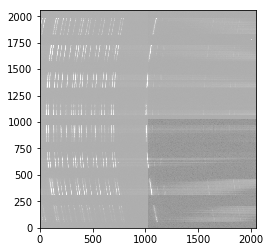

Imtype: twiflat  In filenum: 582 Camera: r Opamp: 1 located at ur
Imtype: twiflat  In filenum: 582 Camera: r Opamp: 2 located at ul
Imtype: twiflat  In filenum: 582 Camera: r Opamp: 3 located at bl
Imtype: twiflat  In filenum: 582 Camera: r Opamp: 4 located at br


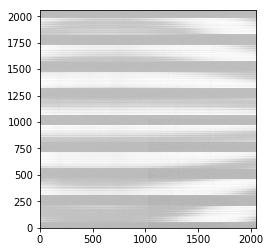

Imtype: twiflat  In filenum: 583 Camera: r Opamp: 1 located at ur
Imtype: twiflat  In filenum: 583 Camera: r Opamp: 2 located at ul
Imtype: twiflat  In filenum: 583 Camera: r Opamp: 3 located at bl
Imtype: twiflat  In filenum: 583 Camera: r Opamp: 4 located at br


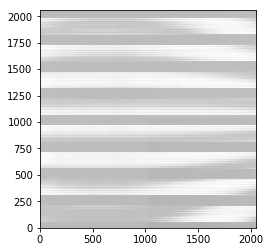

Imtype: twiflat  In filenum: 584 Camera: r Opamp: 1 located at ur
Imtype: twiflat  In filenum: 584 Camera: r Opamp: 2 located at ul
Imtype: twiflat  In filenum: 584 Camera: r Opamp: 3 located at bl
Imtype: twiflat  In filenum: 584 Camera: r Opamp: 4 located at br


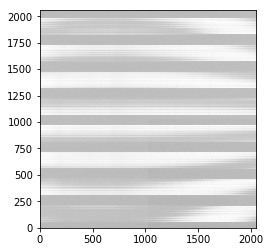

Imtype: twiflat  In filenum: 585 Camera: r Opamp: 1 located at ur
Imtype: twiflat  In filenum: 585 Camera: r Opamp: 2 located at ul
Imtype: twiflat  In filenum: 585 Camera: r Opamp: 3 located at bl
Imtype: twiflat  In filenum: 585 Camera: r Opamp: 4 located at br


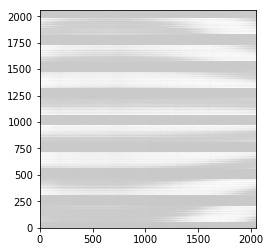

Imtype: twiflat  In filenum: 586 Camera: r Opamp: 1 located at ur
Imtype: twiflat  In filenum: 586 Camera: r Opamp: 2 located at ul
Imtype: twiflat  In filenum: 586 Camera: r Opamp: 3 located at bl
Imtype: twiflat  In filenum: 586 Camera: r Opamp: 4 located at br


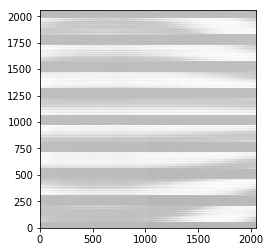

Imtype: twiflat  In filenum: 587 Camera: r Opamp: 1 located at ur
Imtype: twiflat  In filenum: 587 Camera: r Opamp: 2 located at ul
Imtype: twiflat  In filenum: 587 Camera: r Opamp: 3 located at bl
Imtype: twiflat  In filenum: 587 Camera: r Opamp: 4 located at br


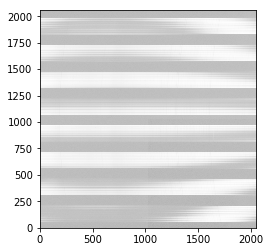

Imtype: twiflat  In filenum: 588 Camera: r Opamp: 1 located at ur
Imtype: twiflat  In filenum: 588 Camera: r Opamp: 2 located at ul
Imtype: twiflat  In filenum: 588 Camera: r Opamp: 3 located at bl
Imtype: twiflat  In filenum: 588 Camera: r Opamp: 4 located at br


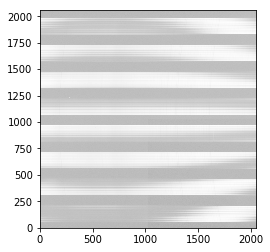

Imtype: twiflat  In filenum: 589 Camera: r Opamp: 1 located at ur
Imtype: twiflat  In filenum: 589 Camera: r Opamp: 2 located at ul
Imtype: twiflat  In filenum: 589 Camera: r Opamp: 3 located at bl
Imtype: twiflat  In filenum: 589 Camera: r Opamp: 4 located at br


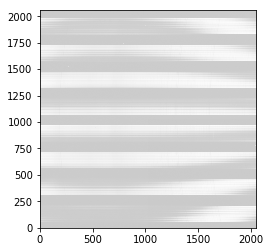

Imtype: twiflat  In filenum: 590 Camera: r Opamp: 1 located at ur
Imtype: twiflat  In filenum: 590 Camera: r Opamp: 2 located at ul
Imtype: twiflat  In filenum: 590 Camera: r Opamp: 3 located at bl
Imtype: twiflat  In filenum: 590 Camera: r Opamp: 4 located at br


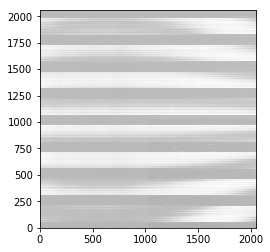

Imtype: twiflat  In filenum: 591 Camera: r Opamp: 1 located at ur
Imtype: twiflat  In filenum: 591 Camera: r Opamp: 2 located at ul
Imtype: twiflat  In filenum: 591 Camera: r Opamp: 3 located at bl
Imtype: twiflat  In filenum: 591 Camera: r Opamp: 4 located at br


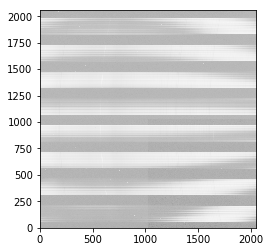

Imtype: science  In filenum: 631 Camera: r Opamp: 1 located at ur
Imtype: science  In filenum: 631 Camera: r Opamp: 2 located at ul
Imtype: science  In filenum: 631 Camera: r Opamp: 3 located at bl
Imtype: science  In filenum: 631 Camera: r Opamp: 4 located at br


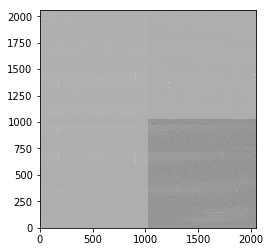

Imtype: science  In filenum: 632 Camera: r Opamp: 1 located at ur
Imtype: science  In filenum: 632 Camera: r Opamp: 2 located at ul
Imtype: science  In filenum: 632 Camera: r Opamp: 3 located at bl
Imtype: science  In filenum: 632 Camera: r Opamp: 4 located at br


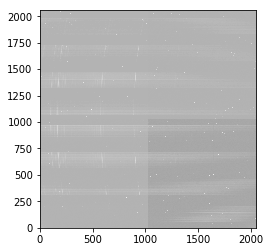

Imtype: science  In filenum: 633 Camera: r Opamp: 1 located at ur
Imtype: science  In filenum: 633 Camera: r Opamp: 2 located at ul
Imtype: science  In filenum: 633 Camera: r Opamp: 3 located at bl
Imtype: science  In filenum: 633 Camera: r Opamp: 4 located at br


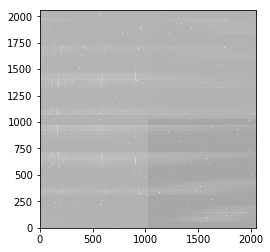

Imtype: science  In filenum: 634 Camera: r Opamp: 1 located at ur
Imtype: science  In filenum: 634 Camera: r Opamp: 2 located at ul
Imtype: science  In filenum: 634 Camera: r Opamp: 3 located at bl
Imtype: science  In filenum: 634 Camera: r Opamp: 4 located at br


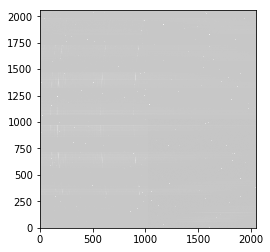

Imtype: fibmap  In filenum: 573 Camera: r Opamp: 1 located at ur
Imtype: fibmap  In filenum: 573 Camera: r Opamp: 2 located at ul
Imtype: fibmap  In filenum: 573 Camera: r Opamp: 3 located at bl
Imtype: fibmap  In filenum: 573 Camera: r Opamp: 4 located at br


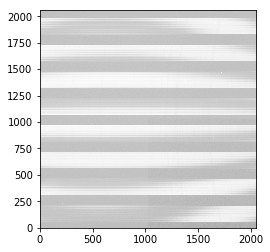

Imtype: fibmap  In filenum: 574 Camera: r Opamp: 1 located at ur
Imtype: fibmap  In filenum: 574 Camera: r Opamp: 2 located at ul
Imtype: fibmap  In filenum: 574 Camera: r Opamp: 3 located at bl
Imtype: fibmap  In filenum: 574 Camera: r Opamp: 4 located at br


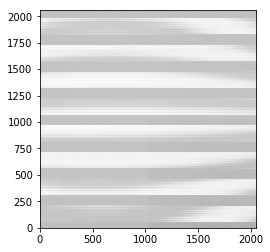

Imtype: fibmap  In filenum: 575 Camera: r Opamp: 1 located at ur
Imtype: fibmap  In filenum: 575 Camera: r Opamp: 2 located at ul
Imtype: fibmap  In filenum: 575 Camera: r Opamp: 3 located at bl
Imtype: fibmap  In filenum: 575 Camera: r Opamp: 4 located at br


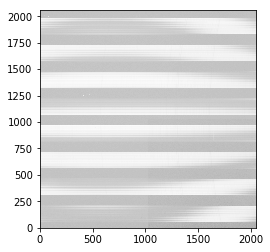

Imtype: fibmap  In filenum: 576 Camera: r Opamp: 1 located at ur
Imtype: fibmap  In filenum: 576 Camera: r Opamp: 2 located at ul
Imtype: fibmap  In filenum: 576 Camera: r Opamp: 3 located at bl
Imtype: fibmap  In filenum: 576 Camera: r Opamp: 4 located at br


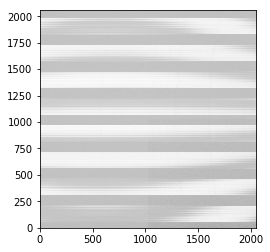

Imtype: fibmap  In filenum: 577 Camera: r Opamp: 1 located at ur
Imtype: fibmap  In filenum: 577 Camera: r Opamp: 2 located at ul
Imtype: fibmap  In filenum: 577 Camera: r Opamp: 3 located at bl
Imtype: fibmap  In filenum: 577 Camera: r Opamp: 4 located at br


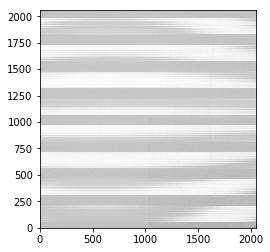

In [17]:
from quickreduce_funcs import stitch_these_camera_data
#transforms = {4: 'l', 1: 'ul', 2: 'u', 3: 'none'}
#camloc = {4:'br',1:'ur',2:'ul',3:'bl'}

if do_stitch:
    stitched_data = {}
    stitched_headers = {}
    for imtype in filenumbers.keys():
        ## Do bias separately. We don't need to cosmic ray subtract them
        if imtype == 'bias':
            continue
        data_dict = data[imtype]
        header_dict = headers[imtype]
        stitched_data[imtype] = {}
        stitched_headers[imtype] = {}
        for camera in data_dict.keys():
            stchd_dat,stchd_headers = stitch_these_camera_data(data_dict,header_dict,filenumbers,camera,imtype,
                                                               common_info,save_each=True)
            stitched_data[imtype][camera] = stchd_dat
            stitched_headers[imtype][camera] = stchd_headers

Imtype: bias  In filenum: 597 Camera: r Opamp: 1 located at ur
Imtype: bias  In filenum: 597 Camera: r Opamp: 2 located at ul
Imtype: bias  In filenum: 597 Camera: r Opamp: 3 located at bl
Imtype: bias  In filenum: 597 Camera: r Opamp: 4 located at br
Imtype: bias  In filenum: 598 Camera: r Opamp: 1 located at ur
Imtype: bias  In filenum: 598 Camera: r Opamp: 2 located at ul
Imtype: bias  In filenum: 598 Camera: r Opamp: 3 located at bl
Imtype: bias  In filenum: 598 Camera: r Opamp: 4 located at br
Imtype: bias  In filenum: 599 Camera: r Opamp: 1 located at ur
Imtype: bias  In filenum: 599 Camera: r Opamp: 2 located at ul
Imtype: bias  In filenum: 599 Camera: r Opamp: 3 located at bl
Imtype: bias  In filenum: 599 Camera: r Opamp: 4 located at br
Imtype: bias  In filenum: 600 Camera: r Opamp: 1 located at ur
Imtype: bias  In filenum: 600 Camera: r Opamp: 2 located at ul
Imtype: bias  In filenum: 600 Camera: r Opamp: 3 located at bl
Imtype: bias  In filenum: 600 Camera: r Opamp: 4 locate

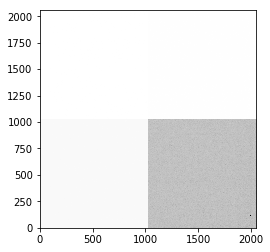

In [18]:
## master bias creation, then stitch
if do_stitch:
    imtype = 'bias'
    data_dict = data.pop(imtype)
    header_dict = headers.pop(imtype)
    stitched_data[imtype] = {}
    stitched_headers[imtype] = {}
    for camera in data_dict.keys():
        stchd_dat,stchd_headers = stitch_these_camera_data(data_dict,header_dict,filenumbers,camera,imtype,
                                                           common_info,save_each=False)
        filenum_3d_array = np.asarray(list(stchd_dat.values()))
        filenum_median_array = np.median(filenum_3d_array,axis=0)
        
        header = list(stchd_headers.values())[0]
        header.add_history("Median Master Bias done by quickreduce on {}".format(date))
        
        outhdu = fits.PrimaryHDU(data=filenum_median_array ,header=header)
        outname = master_stitched_fname_template.format(cam=camera, imtype=imtype,maskname=mask_name, 
                                                       tags=common_info['tags'])
        filename = os.path.join(common_info['datadir'], outname)
        outhdu.writeto( filename ,overwrite=True)

        ## Plot the image
        plt.figure()
        plot_array = outhdu.data - np.min(outhdu.data) + 1e-4
        plt.imshow(np.log(plot_array),'gray',origin='lowerleft')
        plt.savefig(filename.replace('.fits','.png'),dpi=1200)
        plt.show()
        
        stitched_headers[imtype][camera] = header
        stitched_data[imtype][camera] = filenum_median_array

In [19]:
## Now that stitching is complete. opamps = None
common_info['opamps'] = None
data, headers = stitched_data, stitched_headers
del stitched_data, stitched_headers

In [20]:
if do_bias:
    if data is None:
        common_info['datadir'] = raw_stitched_dir
        data, headers = get_all_filedata(filenum_dict=filenumbers, **common_info)
    elif 'bias' in data.keys():
        master_bias_data = data.pop('bias')
        master_bias_headers = headers.pop('bias')
    elif master_bias_data is None:
        print("Can't find the bias data!")
        raise(IOError)     

In [21]:
filenumbers.pop('bias')
common_info['datadir'] = product_dir
common_info['tags'] = '.b'    

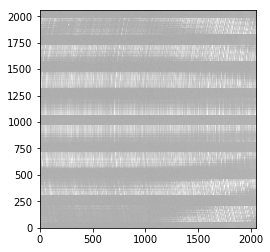

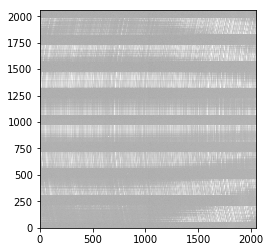

Completed bias subtraction for thar
Results saved to C:\Users\kremin\OneDrive\Research\M2FSReductions\A02\data_products


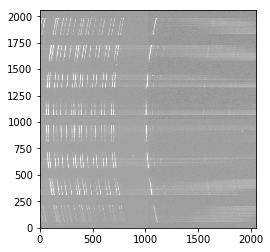

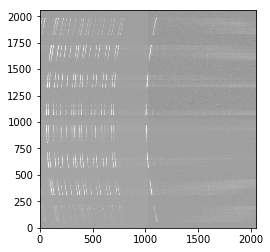

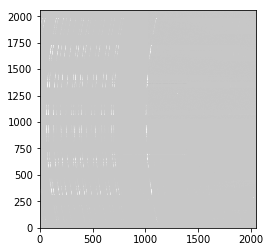

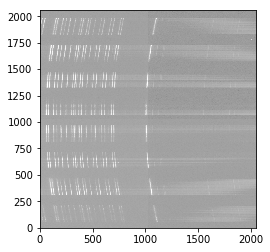

Completed bias subtraction for comp
Results saved to C:\Users\kremin\OneDrive\Research\M2FSReductions\A02\data_products


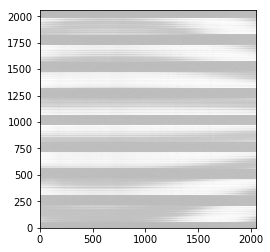

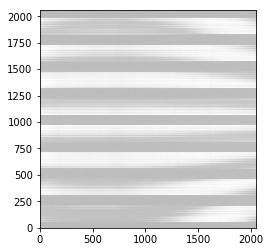

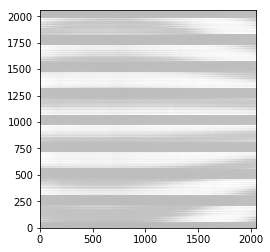

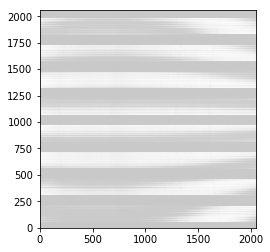

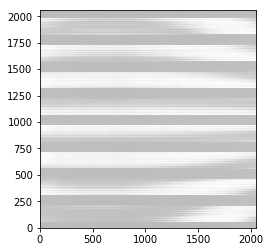

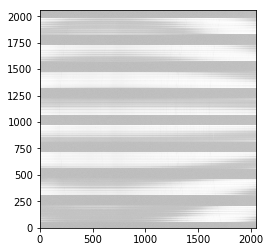

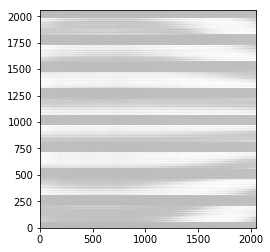

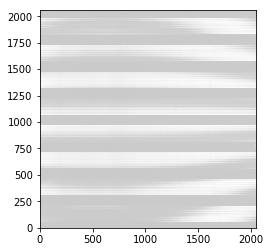

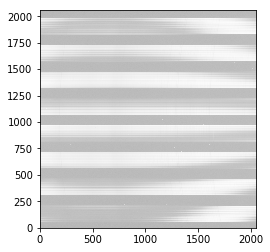

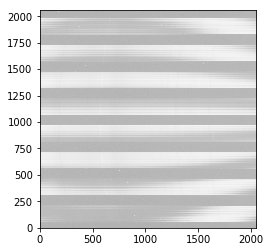

Completed bias subtraction for twiflat
Results saved to C:\Users\kremin\OneDrive\Research\M2FSReductions\A02\data_products


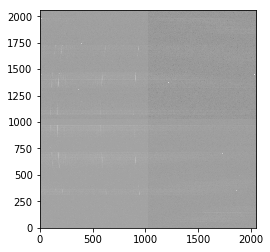

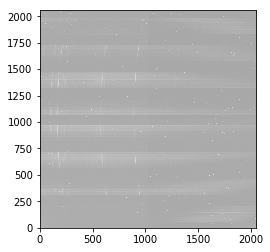

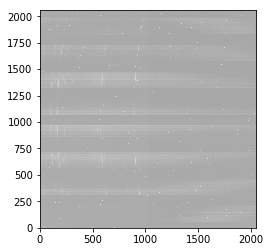

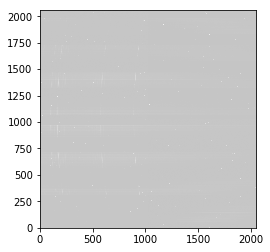

Completed bias subtraction for science
Results saved to C:\Users\kremin\OneDrive\Research\M2FSReductions\A02\data_products


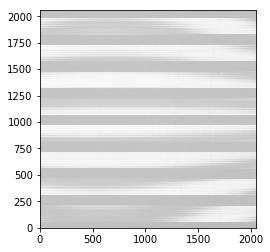

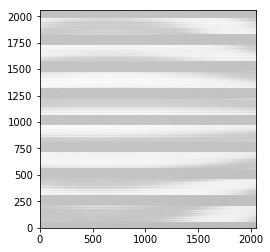

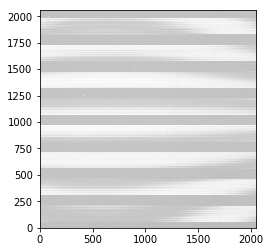

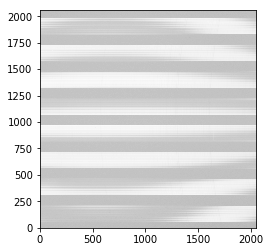

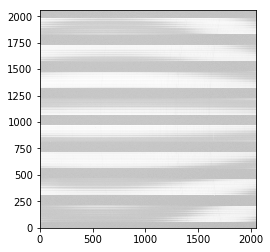

Completed bias subtraction for fibmap
Results saved to C:\Users\kremin\OneDrive\Research\M2FSReductions\A02\data_products


In [26]:
if do_bias:
    master_bias_data = bias_array_dict
    master_bias_headers = bias_header_dict
    for camera,master_bias in master_bias_data.items():
        for imtype,filenums in filenumbers.items():
            for filenum in filenums:
                filnumarray = data[imtype][camera][filenum].astype(float)
                header = headers[imtype][camera][filenum]
                filnumarray -= master_bias.astype(float)
                header.add_history("Bias Subtracted done by quickreduce on {}".format(date))
                outhdu = fits.PrimaryHDU(data=filnumarray ,header=header)  
                outname = common_info['template'].format(cam=camera,imtype=imtype, maskname=mask_name,
                                                            filenum=filenum,tags=common_info['tags'])

                filename = os.path.join(common_info['datadir'], outname)
                outhdu.writeto( filename ,overwrite=True)

                ## Plot the image
                plt.figure()
                plot_array = outhdu.data - np.min(outhdu.data) + 1e-4
                plt.imshow(np.log(plot_array),'gray',origin='lowerleft')
                plt.savefig(filename.replace('.fits','.png'),dpi=1200)
                plt.show()

                data[imtype][camera][filenum] = header
                headers[imtype][camera][filenum] = filnumarray
            print("Completed bias subtraction for {}".format(imtype))
            print("Results saved to {}".format(common_info['datadir']))

In [27]:
old_tag = common_info['tags']
new_tag = common_info['tags']+'c'

In [28]:
import PyCosmic    
if do_cr:
    if data is None:
        data, headers = get_all_filedata( filenum_dict=filenumbers, **common_info )
    for datatype in data.keys():
        for camera in data[datatype].keys():
            for filenum in filenumbers[datatype]:
                filename = common_info['template'].format(cam=camera, imtype=datatype, maskname=mask_name,
                                                             filenum=filenum, tags=old_tag)
                filename = os.path.join(common_info['datadir'],filename)
                savefile = filename.replace(old_tag+'.fits',new_tag+'.fits')
                maskfile = filename.replace(old_tag+'.fits',old_tag+'.crmask.fits')
                print("\nFor image type: {}, shoe: {},   filenum: {}".format(datatype,camera,filenum))
                outdat,pycosmask,pyheader = PyCosmic.detCos(filename,maskfile,savefile,rdnoise='ENOISE',sigma_det=8,
                                                            gain='EGAIN',verbose=True,return_data=True)
                data[datatype][camera][filenum] = outdat
                ## Plot the image
                plt.figure()
                pycosmask = pycosmask - np.min(pycosmask) + 1e-4
                plt.imshow(np.log(pycosmask),'gray',origin='lowerleft')
                plt.savefig(maskfile.replace('.fits','.png'),dpi=1200)
                plt.close()
                ## Plot the image
                plt.figure()
                pycos = outdat - np.min(outdat) + 1e-4
                plt.imshow(np.log(pycos),'gray',origin='lowerleft')
                plt.savefig(filename.replace('.fits','.png'),dpi=1200)
                plt.close()
                


For image type: thar, shoe: r,   filenum: 627
A value of 2.634 is used for the electron read-out noise.
Start the detection process using 2 CPU cores.
Start iteration 1
Total number of detected cosmics: 36 out of 4210688 pixels
Start iteration 2
Total number of detected cosmics: 58 out of 4210688 pixels
Start iteration 3
Total number of detected cosmics: 62 out of 4210688 pixels
Start iteration 4
Total number of detected cosmics: 63 out of 4210688 pixels
Start iteration 5
Total number of detected cosmics: 63 out of 4210688 pixels
Cleaned image is stored in file: C:\Users\kremin\OneDrive\Research\M2FSReductions\A02\data_products\r_thar_0627_A02_stitched.bc.fits
Cosmics mask is stored in file: C:\Users\kremin\OneDrive\Research\M2FSReductions\A02\data_products\r_thar_0627_A02_stitched.b.crmask.fits


C:\Users\kremin\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.



For image type: thar, shoe: r,   filenum: 635
A value of 2.634 is used for the electron read-out noise.
Start the detection process using 2 CPU cores.
Start iteration 1
Total number of detected cosmics: 71 out of 4210688 pixels
Start iteration 2
Total number of detected cosmics: 125 out of 4210688 pixels
Start iteration 3
Total number of detected cosmics: 140 out of 4210688 pixels
Start iteration 4
Total number of detected cosmics: 141 out of 4210688 pixels
Start iteration 5
Total number of detected cosmics: 141 out of 4210688 pixels
Cleaned image is stored in file: C:\Users\kremin\OneDrive\Research\M2FSReductions\A02\data_products\r_thar_0635_A02_stitched.bc.fits
Cosmics mask is stored in file: C:\Users\kremin\OneDrive\Research\M2FSReductions\A02\data_products\r_thar_0635_A02_stitched.b.crmask.fits

For image type: comp, shoe: r,   filenum: 628
A value of 2.634 is used for the electron read-out noise.
Start the detection process using 2 CPU cores.
Start iteration 1
Total number of de

Total number of detected cosmics: 50 out of 4210688 pixels
Start iteration 2
Total number of detected cosmics: 85 out of 4210688 pixels
Start iteration 3
Total number of detected cosmics: 101 out of 4210688 pixels
Start iteration 4
Total number of detected cosmics: 102 out of 4210688 pixels
Start iteration 5
Total number of detected cosmics: 102 out of 4210688 pixels
Cleaned image is stored in file: C:\Users\kremin\OneDrive\Research\M2FSReductions\A02\data_products\r_twiflat_0587_A02_stitched.bc.fits
Cosmics mask is stored in file: C:\Users\kremin\OneDrive\Research\M2FSReductions\A02\data_products\r_twiflat_0587_A02_stitched.b.crmask.fits

For image type: twiflat, shoe: r,   filenum: 588
A value of 2.634 is used for the electron read-out noise.
Start the detection process using 2 CPU cores.
Start iteration 1
Total number of detected cosmics: 111 out of 4210688 pixels
Start iteration 2
Total number of detected cosmics: 190 out of 4210688 pixels
Start iteration 3
Total number of detected

Total number of detected cosmics: 42 out of 4210688 pixels
Start iteration 2
Total number of detected cosmics: 72 out of 4210688 pixels
Start iteration 3
Total number of detected cosmics: 82 out of 4210688 pixels
Start iteration 4
Total number of detected cosmics: 83 out of 4210688 pixels
Start iteration 5
Total number of detected cosmics: 83 out of 4210688 pixels
Cleaned image is stored in file: C:\Users\kremin\OneDrive\Research\M2FSReductions\A02\data_products\r_fibmap_0574_A02_stitched.bc.fits
Cosmics mask is stored in file: C:\Users\kremin\OneDrive\Research\M2FSReductions\A02\data_products\r_fibmap_0574_A02_stitched.b.crmask.fits

For image type: fibmap, shoe: r,   filenum: 575
A value of 2.634 is used for the electron read-out noise.
Start the detection process using 2 CPU cores.
Start iteration 1
Total number of detected cosmics: 82 out of 4210688 pixels
Start iteration 2
Total number of detected cosmics: 131 out of 4210688 pixels
Start iteration 3
Total number of detected cosmic

In [29]:
common_info['tags'] = new_tag
del old_tag, new_tag

In [65]:
data = None
common_info['tags'] = '.bc'

In [66]:
if do_flat:
    if data is None:
        data, headers = get_all_filedata( filenum_dict=filenumbers, **common_info )
    elif  'twiflat' in data.keys():
        twiflat_array_dict = data.pop('twiflat')
        twiflat_header_dict = headers.pop('twiflat')
    elif twiflat_array_dict is None:
        print("Can't find the twilight flats!")

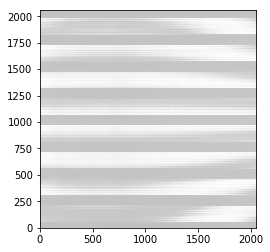

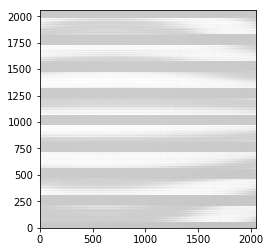

In [58]:
## master flat/fibermap creation, then stitch
if do_stitch:
    for imtype in ['twiflat','fibmap']:
        #data_dict = data.pop(imtype)
        #header_dict = headers.pop(imtype)
        for camera in data[imtype].keys():
            filenum_3d_array = np.asarray(list(data[imtype][camera].values()))
            header =list(headers[imtype][camera].values())[0]
            
            filenum_summed_array = filenum_3d_array.sum(axis=0)
            header.add_history("Summed Master {} done by quickreduce on {}".format(imtype,date))

            outhdu = fits.PrimaryHDU(data=filenum_summed_array ,header=header)
            outname = master_stitched_fname_template.format(cam=camera, imtype=imtype,maskname=mask_name, 
                                                           tags=common_info['tags'])
            filename = os.path.join(common_info['datadir'], outname)
            outhdu.writeto( filename ,overwrite=True)

            ## Plot the image
            plt.figure()
            plot_array = outhdu.data - np.min(outhdu.data) + 1e-4
            plt.imshow(np.log(plot_array),'gray',origin='lowerleft')
            plt.savefig(filename.replace('.fits','.png'),dpi=1200)
            plt.show()

            headers[imtype][camera] = header
            data[imtype][camera] = filenum_median_array

In [67]:
common_info['tags'] = common_info['tags']+'f' 

In [68]:
if do_flat:
    master_twiflat_data = data['twiflat']
    for camera,master_twiflat in master_twiflat_data.items():
        for imtype in data.keys():
            if imtype in ['twiflat','fibmap']:
                continue
            datadict = data[imtype][camera]
            headerdict = headers[imtype][camera]
            for filnum,filearray in datadict.items():
                filearray = filearray.astype(float)
                header = headerdict[filnum]
                filearray /= master_twiflat.astype(float)
                header.add_history("Flat correction done by quickreduce on {}".format(date))
                outhdu = fits.PrimaryHDU(data=filearray ,header=header)
                filename = common_info['template'].format(cam=camera, imtype=imtype, 
                                                             maskname=mask_name, 
                                                             filenum=filnum, tags=common_info['tags'])
                filename = os.path.join(common_info['datadir'], filename)
                outhdu.writeto( filename ,overwrite=True)

                ## Plot the image
                plt.figure()
                plot_array = outhdu.data - np.min(outhdu.data) + 1e-4
                plt.imshow(np.log(plot_array),'gray',origin='lowerleft')
                plt.savefig(filename.replace('.fits','.png'),dpi=1200)
                plt.show() 
                
                data[imtype][camera][filnum] = header
                headers[imtype][camera][filnum] = filearray

        print("Completed flattening for {}".format(imtype))
        print("Results saved to {}".format(common_info['datadir']))

AttributeError: 'dict' object has no attribute 'astype'

In [72]:
if print_headers:
    print(list(headers['science'][camera][631]))
    #print(list(headers['science'][camera].values())[0].keys)

['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BUNIT', 'ORIGIN', 'OBSERVER', 'TELESCOP', 'SITENAME', 'SITEALT', 'SITELAT', 'SITELONG', 'TIMEZONE', 'DATE-OBS', 'UT-DATE', 'UT-TIME', 'UT-END', 'LC-TIME', 'NIGHT', 'MJD', 'INSTRUME', 'SCALE', 'EGAIN', 'ENOISE', 'NOPAMPS', 'DISPAXIS', 'RA', 'RA-D', 'DEC', 'DEC-D', 'EQUINOX', 'EPOCH', 'AIRMASS', 'ST', 'ROTANGLE', 'TEL-AZIM', 'TEL-ELEV', 'T-DOME', 'T-CELL', 'T-TRUSS', 'WX-TEMP', 'FILENAME', 'OBJECT', 'COMMENT', 'EXPTYPE', 'EXPTIME', 'NLOOPS', 'LOOP', 'BINNING', 'SPEED', 'DATASEC', 'TRIMSEC', 'SUBRASTR', 'TEMPCCD', 'SHOE', 'SLIDE', 'SLIDEENC', 'SLIDESTP', 'LO-ELEV', 'HI-AZIM', 'HI-ELEV', 'FOCUS', 'FILTER', 'SLITNAME', 'SLIT1', 'SLIT2', 'SLIT3', 'SLIT4', 'SLIT5', 'SLIT6', 'SLIT7', 'SLIT8', 'FF-THNE', 'FF-THAR', 'FF-NE', 'FF-HGAR', 'FF-XE', 'FF-QRTZ', 'PLATE', 'PLATESTP', 'TEMP01', 'TEMP02', 'TEMP03', 'TEMP04', 'TEMP05', 'TEMP06', 'TEMP07', 'TEMP08', 'TEMP09', 'SOFTWARE', 'FITSVERS', 'FIBER101', 'FIBER102', 'FIBER103', 'FIBER104', 'FIBER105'

In [ ]:
if do_apcut:
    if data is None:
        data, headers = get_all_stitcheddata( filnum_dict=filenumbers, **common_info )
    elif 'fibmap' in data.keys():
        fibermap_array_dict = data.pop('fibmap')
        fibermap_header_dict = headers.pop('fibmap')
    elif  fibermap_array_dict is None:
        print("Can't find the fiber maps!")

In [ ]:
if do_apcut:
    master_fibm_data_dict = {}
    master_fibm_header_dict = {}

    for camera,camera_data_dict in fibermap_array_dict.items():
        
        opamp = 'stitched'
        
        heads = fibm_header_dict[camera]
        master_bias = master_bias_data_dict[camera]
        header = list(heads.values())[0]
        
        if header['SHOE'].lower() != camera:
            print("In fibermap: Camera did not match the header's shoe variable")
            
        
        opamparray = np.asarray(list(heads.values())).sum(axis=0)
        header.add_history("Master fibermap done by quickreduce on {}".format(date))
        
        outhdu = fits.PrimaryHDU(data=opamparray ,header=header)  
        outname = master_stitched_fname_template.format(cam=camera, imtype="fibermap", 
                                                        maskname=mask_name, 
                                                        tags=common_info['tags'])
        outname = os.path.join(common_info['dirname'],outname)
        outhdu.writeto( outname ,overwrite=True)

        if make_debug_plots:
            debug_plots(opamparrays,camera,filetype='Fibermap',typical_sep=typical_sep,np_oper=np.sum)
        master_fibm_data_dict[camera] = opamparray
        master_fibm_header_dict[camera] = header

    print("Completed master fibermap")
    print("Results saved to {}".format(common_info['datadir']))
    #del fibm_array_dict, fibm_header_dict

# else:
#     ## load in master fibermap
#     print("Loaded master fibermap")
#     print("Loaded from {}".format(common_info['datadir']))
         
    
filenumbers.pop('fibmap')